In [1]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.10.0+cu102


In [2]:
import torch_geometric
torch_geometric.__version__

'2.0.2'

In [3]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch.optim as optim
import time

import networkx as nx
import numpy as np
import pandas as pd

from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

In [36]:
def get_feature(data, is_monitored, k=90):
  k = min(len(data), k) # monitoring period
  SIR = [0., 0., 0.]
  if is_monitored:
    for i in range(k):
      SIR[data[i]] += 1
  return SIR, int(data[k-1])

In [37]:
def get_data(file_csv, file_gexf, m=15, k=30):
  # Reading the data
  dataframe = pd.read_csv(file_csv, index_col=0)
  G_test = nx.relabel.convert_node_labels_to_integers(nx.readwrite.gexf.read_gexf(file_gexf))
  num_nodes = len(dataframe.columns)

  # updating features and labels
  for node in range(len(dataframe.columns)):
    G_test.nodes[node]['x'], G_test.nodes[node]['label']  = get_feature(dataframe[str(node)], is_monitored=node<m, k=k)

  # masks for train and test nodes
  train_mask = np.array([i<m for i in range(num_nodes)])
  test_mask = np.array([not elem for elem in train_mask])
  
  # converting networkx.Graph to torch_geometric.data.Data
  data = pyg_utils.from_networkx(G_test)
  data.train_mask = torch.tensor(train_mask)
  data.test_mask = torch.tensor(test_mask)

  return data, G_test

In [109]:
datalist = []
G_list = []
path = "Datasets/BA/500_nodes"
m = 75
k = 75
for i in range(256):
  filename = path + "/test"
  temp_data, temp_G = get_data(f"{filename}{i}.csv", f"{filename}{i}.gexf", m=m, k=k)
  datalist.append(temp_data)
  G_list.append(temp_G)

{'label': 1, 'x': [10.0, 65.0, 0.0]}

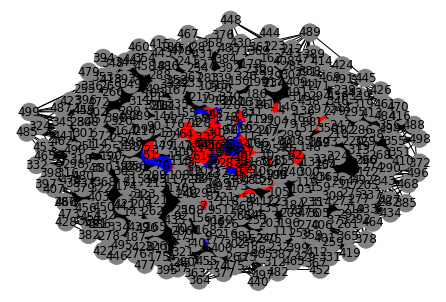

In [110]:
# Visualising the graph
idx = 15

colors = {
    0:'green',  # S
    1:'red',    # I
    2:'blue'    # R
}

color_map = [colors[G_list[idx].nodes[node]['label']] for node in range(m)] + ['grey']*(datalist[idx].num_nodes - m) # assigning color to each node

nx.draw(G_list[idx], node_color=color_map, with_labels=True)
G_list[idx].nodes[16]

In [111]:
data = datalist[3]
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[500, 3], edge_index=[2, 14550], label=[500], id=[14550], train_mask=[500], test_mask=[500])
Number of nodes: 500
Number of edges: 14550
Average node degree: 29.10
Number of training nodes: 75
Training node label rate: 0.15
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [112]:
class GCN(torch.nn.Module):

    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.dropout = 0.3
        self.layer1 = pyg_nn.GCNConv(3, 32)
        self.layer2 = pyg_nn.GCNConv(32, 64)
        
        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, 3)
  

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.layer1(x, edge_index)
        x = F.relu(x)
        h1 = F.dropout(x, self.dropout, training=self.training)

        h1 = self.layer2(h1, edge_index)
        h1 = F.relu(h1)
        h2 = F.dropout(h1, self.dropout, training=self.training)

        # h2 = self.layer3(h2, edge_index)
        # h2 = F.relu(h2)
        # h3 = F.dropout(h2, self.dropout, training=self.training)

        h4 = F.relu(self.linear1(h2))

        return F.log_softmax(self.linear2(h4), dim=1)
        # return F.log_softmax(h2, dim=1)
    
    # def loss(self, pred, label):
    #     return self.criterion(pred, label)

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()
        self.classifier.reset_parameters()

In [113]:
loader = DataLoader(datalist, batch_size=32, shuffle=True)

In [ ]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)  # Define optimizer.

def train(data):
  model.train()
  optimizer.zero_grad()
  out = model(data)
  loss = F.nll_loss(out[data.train_mask], data.label[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test(data):
  model.eval()
  with torch.no_grad():
    pred = model(data)[data.test_mask]
    original_labels = data.label[data.test_mask]
  predicted_labels = [np.argmax(scores) for scores in pred.detach().numpy()]
  accuracy = sum([original_labels[i] == predicted_labels[i] for i in range(len(predicted_labels))])/len(predicted_labels)
  loss = F.nll_loss(pred, original_labels)
  return loss, accuracy


training_losses = []
val_losses = []
val_accuracies = []
patience_count = 0
patience = 50
earlyStop = False
best_loss = 500
best_accuracy = 0
epoch = 0
while not earlyStop:
  total_loss = 0
  val_loss = 0
  val_acc = 0
  
  for data in loader:
    loss = train(data)
    total_loss += loss
    if epoch % 10 ==0:
      temp_loss, temp_acc = test(data)
      val_loss += temp_loss
      val_acc += temp_acc
  training_losses.append(total_loss/len(loader))
  
  if epoch % 10 == 0:
    val_losses.append(val_loss/len(loader))
    val_accuracies.append(val_acc/len(loader))
    patience_count += 1
    if best_loss > val_losses[-1]:
      best_loss = val_losses[-1]
      best_accuracy = val_accuracies[-1]
      patience_count = 0
      torch.save(model.state_dict(), "best-model.pt")
    if patience_count == patience // 10:
      earlyStop = True
  
    print(f"{epoch}: training_loss = {training_losses[-1]}, val_loss = {val_losses[-1]}, best_loss = {best_loss}")
  epoch += 1

0: training_loss = 0.8435394167900085, val_loss = 0.9133932590484619, best_loss = 0.9133932590484619
10: training_loss = 0.6317892074584961, val_loss = 0.7104371786117554, best_loss = 0.7104371786117554
20: training_loss = 0.5794496536254883, val_loss = 0.650469183921814, best_loss = 0.650469183921814
30: training_loss = 0.5302901268005371, val_loss = 0.6340527534484863, best_loss = 0.6340527534484863
40: training_loss = 0.493672639131546, val_loss = 0.6402535438537598, best_loss = 0.6340527534484863
50: training_loss = 0.47880393266677856, val_loss = 0.6479587554931641, best_loss = 0.6340527534484863


In [ ]:
plt.plot([i*10 for i in range(len(val_losses))], val_losses, label="Val-Loss")
plt.plot([i*10 for i in range(len(val_losses))], val_accuracies, label="Val-Accuracies")
plt.title(f"Performance on Test data\nM = {m} and K = {k}\nBest Accuracy = {float(int(10000*best_accuracy.detach().numpy()))/100}")
plt.grid()
plt.legend(loc='best')
plt.show();

In [ ]:
plt.plot([x.item() for x in training_losses])